# VectorDB Scan

Exploring the possibility of using VectorDB algorithms to find similar sequences in the database.
It seems to me that the graph construction problem is a process of drawing edges between similar nodes.
This is especially true when considering inferred nodes (based on the intersections of given nodes). This
is because, it seems to me intuitively, that the patristic distances between everything would approach
an edit distance. It would therefore be optimal to construct the graph starting from these distances.

In [51]:
import hnswlib
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

Experimenting with hnswlib

In [52]:
conv = lambda x: [ int(x) for x in x ]

data = [
    conv('01101100'),
    conv('01010010'),
    conv('11100000'),
    conv('00000000'),
    conv('00101001'),
]

ids = np.arange(len(data))

dim = len(data[0])
num_elements = len(data)

# Create the index

# euclidean^2 distance, just counts the number of different bits 
p = hnswlib.Index(space = 'l2', dim = dim) # possible options are l2, cosine or ip

p.init_index(max_elements = num_elements, ef_construction = 200, M = 16)
p.add_items(data, ids)

p.set_ef(200) # ef should always be > k
labels, distances = p.knn_query(data, k = 3)

labels = [ list(x[1:]) for x in labels ]
distances = [ list(x[1:]) for x in distances ]

results = list(zip(ids, labels, distances))

for result in results:
    print(result)

(0, [2, 4], [3.0, 3.0])
(1, [3, 2], [3.0, 4.0])
(2, [0, 3], [3.0, 3.0])
(3, [2, 4], [3.0, 3.0])
(4, [0, 3], [3.0, 3.0])


# Performing KNN

In [53]:
def parse_nodes(path):
    contents = open(path).read().splitlines()
    nodes = [[int(x) for x in line.split()] for line in contents]
    nodes = [ set(x) for x in nodes ]
    return nodes


def nodes_to_matrix(nodes):
    dim = max([max(x) for x in nodes]) # attributes are 1-indexed
    node_amnt = len(nodes)

    # Convert to sparse matrix
    data = np.zeros((node_amnt, dim))
    for i in range(node_amnt):
        for x in nodes[i]:
            data[i][x-1] = 1
    
    return data


def build_index(data, ef_const, M):
    node_amnt = len(data)
    dim = len(data[0])

    # using l2 distance
    # index = hnswlib.Index(space='l2', dim=dim)
    index = hnswlib.BFIndex(space='l2', dim=dim)
    # index.init_index(max_elements=node_amnt, ef_construction=ef_const, M=M)
    index.init_index(max_elements=node_amnt)
    index.add_items(data)
    return index


def knn(index, data, k, ef):
    k += 1 # first result is always the node itself
    # index.set_ef(ef)
    
    labels, distances = index.knn_query(data, k=k)
    
    ids = [x[0] for x in labels]
    labels = [x[1:].tolist() for x in labels]
    distances = [x[1:].tolist() for x in distances]
    results = [list(zip(x, y)) for x, y in zip(labels, distances)]
    results = list(zip(ids, results))
    return results

In [54]:
path = '../../../data/example/6.txt'
nodes = parse_nodes(path)
matrix = nodes_to_matrix(nodes)
index = build_index(matrix, ef_const=100, M=5)
results = knn(index, matrix, k=3, ef=25)

print(results)


[(0, [(1, 1.0), (2, 1.0), (3, 2.0)]), (1, [(0, 1.0), (3, 1.0), (2, 2.0)]), (2, [(0, 1.0), (3, 1.0), (1, 2.0)]), (3, [(1, 1.0), (2, 1.0), (4, 1.0)]), (4, [(3, 1.0), (5, 1.0), (1, 2.0)]), (5, [(4, 1.0), (3, 2.0), (1, 3.0)])]


# KNN to Solution Graph

In [55]:
def best_candidates(node_key, root, candidates):
    seen = set()
    subsets = []
    supersets = []
    siblings = []
    
    for candidate in candidates:
        novelty = node_key[candidate] - seen
        
        if len(novelty) > 0:
            seen.update(novelty)
            intersection = node_key[root] & node_key[candidate]
            
            if intersection == node_key[root]:
                supersets.append(candidate)
            elif intersection == node_key[candidate]:
                subsets.append(candidate)
            else:
                siblings.append(candidate)
    return subsets, supersets, siblings


print(nodes)

for result in results:
    root = result[0]
    candidates = [x[0] for x in result[1]]
    best = best_candidates(nodes, root, candidates)
    
    print(f'Potential: {root} and {candidates}')
    print(f'{best[0]} -> {root} -> {best[1]}')
    print(f'Siblings: {best[2]}')

    # subsets, supersets, siblings = best_candidates

[{2}, {1, 2}, {2, 3}, {1, 2, 3}, {1, 2, 3, 4}, {1, 2, 3, 4, 5}]
Potential: 0 and [1, 2, 3]
[] -> 0 -> [1, 2]
Siblings: []
Potential: 1 and [0, 3, 2]
[0] -> 1 -> [3]
Siblings: []
Potential: 2 and [0, 3, 1]
[0] -> 2 -> [3]
Siblings: []
Potential: 3 and [1, 2, 4]
[1, 2] -> 3 -> [4]
Siblings: []
Potential: 4 and [3, 5, 1]
[3] -> 4 -> [5]
Siblings: []
Potential: 5 and [4, 3, 1]
[4] -> 5 -> []
Siblings: []


It appears the **K** value is very tricky. If it's too small, useful edges will be missed. if it's too large, redundant edges will be drawn.
The ideal K value is different per node, so it will be necessary to choose a conservative value and prune redundant edges later.

# Testing w/ Real Data

In [56]:
path = '../../../data/dirty/1109.txt'
nodes = parse_nodes(path)
matrix = nodes_to_matrix(nodes)
print('Preparred data.')

ef_const = 10000
ef = ef_const
M = 200
k = M

print('Building index...')
index = build_index(matrix, ef_const=ef_const, M=M)
print('Performing knn search...')
results = knn(index, matrix, k=k, ef=ef)

Preparred data.
Building index...
Performing knn search...


In [57]:
edges = dict()

for result in results:
    root = result[0]
    potential = [x[0] for x in result[1]]
    subsets, supersets, siblings = best_candidates(nodes, root, potential)
    
    def edge(x, y):
        x = tuple(x)
        y = tuple(y)
        
        if x in edges:
            edges[x].append(y)
        else:
            edges[x] = [y]
    
    for subset in subsets:
        edge(nodes[subset], nodes[root])
    
    for superset in supersets:
        edge(nodes[root], nodes[superset])
    
    # for sibling in siblings:
    #     inter = nodes[root] & nodes[sibling]
    #     edge(inter, nodes[root])
    #     edge(inter, nodes[sibling])

graph = nx.DiGraph(edges)
print('Results collected in graph.')
graph = nx.transitive_reduction(graph)
print('Transitive reduction complete.')

Results collected in graph.
Transitive reduction complete.


## Verifying integrity with solution

In [58]:
def load_soln(path): # iterate each line as an edge
    parseNode = lambda x: tuple(sorted([int(y) for y in x.split(' ')]))
    graph = nx.read_edgelist(path, create_using=nx.DiGraph(), nodetype=parseNode, delimiter=' -> ')

    print(list(graph.edges())[:500])
    print(f"There are {len(graph.nodes())} nodes and {len(graph.edges())} edges")
    
    return graph

path = '../../../data/soln/1109.txt'
soln_graph = load_soln(path)

[((1, 2, 3, 4, 5), (1, 2, 3, 4, 5, 193, 248, 424, 438, 457, 541, 596, 640)), ((1, 2, 3, 5), (1, 2, 3, 4, 5)), ((1, 2, 3, 5), (1, 2, 3, 5, 11)), ((1, 2, 3, 5), (1, 2, 3, 5, 17)), ((1, 2, 3, 5), (1, 2, 3, 5, 19)), ((1, 2, 3, 5), (1, 2, 3, 5, 29)), ((1, 2, 3, 5), (1, 2, 3, 5, 33)), ((1, 2, 3, 5), (1, 2, 3, 5, 83)), ((1, 2, 3, 5), (1, 2, 3, 5, 193)), ((1, 2, 3, 5), (1, 2, 3, 5, 196)), ((1, 2, 3, 5), (1, 2, 3, 5, 452)), ((1, 2, 3, 5), (1, 2, 3, 5, 385)), ((1, 2, 3, 5), (1, 2, 3, 5, 248)), ((1, 2, 3, 5), (1, 2, 3, 5, 206)), ((1, 2, 3, 5), (1, 2, 3, 5, 563)), ((1, 2, 3, 5), (1, 2, 3, 5, 194)), ((1, 2, 3, 5), (1, 2, 3, 5, 100)), ((1, 2, 3, 5), (1, 2, 3, 5, 620)), ((1, 2, 3, 5), (1, 2, 3, 5, 405)), ((1, 2, 3, 5), (1, 2, 3, 5, 302)), ((1, 2, 3, 5), (1, 2, 3, 5, 96)), ((1, 2, 3, 5), (1, 2, 3, 5, 440)), ((1, 2, 3, 5), (1, 2, 3, 5, 171)), ((1, 2, 3, 5), (1, 2, 3, 5, 150)), ((1, 2, 3, 5), (1, 2, 3, 5, 116)), ((1, 2, 3, 5), (1, 2, 3, 5, 327)), ((1, 2, 3, 5), (1, 2, 3, 5, 468)), ((1, 2, 3, 5), (1, 2, 

In [62]:
print(list(graph.edges())[0::100])

found_edges = {(tuple(sorted(x)), tuple(sorted(y))) for x, y in graph.edges()}
soln_edges = {(tuple(sorted(x)), tuple(sorted(y))) for x, y in soln_graph.edges()}

diff_edges = found_edges - soln_edges

print(f"Found {len(found_edges)}, soln total {len(soln_edges)}, {len(diff_edges)} different")

for p, c in diff_edges:
    sub = set(p) & set(c) == set(p)
    if not sub:
        print('sub', sub)
# looks like all the edges are roughly valid

diff_lens = [len(c) - len(p) for p, c in diff_edges]
print(f"diff lens: {diff_lens[::50]}")

found_lens = [len(c) - len(p) for p, c in found_edges]
print(f"found lens: {found_lens[::1000]}")

[((1, 2, 3, 5), (1, 2, 3, 5, 11)), ((2, 3, 5), (1, 2, 3, 5)), ((1, 2, 3, 5, 264, 11, 673, 422, 295, 679, 680, 42, 681, 682, 685, 563, 310, 570, 68, 327, 329, 468, 353, 228, 103, 238, 496), (1, 2, 3, 5, 264, 11, 673, 422, 295, 679, 680, 42, 681, 682, 685, 563, 310, 570, 68, 327, 329, 468, 346, 353, 228, 103, 238, 496)), ((1, 2, 3, 5, 584, 276), (1, 2, 3, 5, 101, 325, 519, 584, 11, 369, 211, 276, 318)), ((1, 2, 674, 5, 584, 468), (1, 2, 674, 68, 5, 584, 468)), ((1, 2, 3, 5, 261, 652, 144, 529, 658, 662, 153, 538, 669, 670, 674, 420, 293, 170, 171, 426, 558, 691, 439, 55, 189, 448, 717, 212, 348, 736, 610, 484, 628, 378, 638, 639), (1, 2, 3, 5, 261, 652, 144, 529, 658, 662, 153, 538, 669, 670, 674, 420, 293, 170, 171, 426, 558, 691, 439, 55, 189, 448, 204, 717, 212, 348, 736, 610, 484, 628, 378, 638, 639)), ((1, 2, 3, 5, 261, 652, 144, 529, 18, 658, 662, 153, 538, 670, 674, 420, 293, 426, 171, 558, 691, 55, 439, 448, 200, 585, 75, 212, 348, 477, 96, 736, 610, 738, 484, 628, 378, 638, 639)

### Out degrees

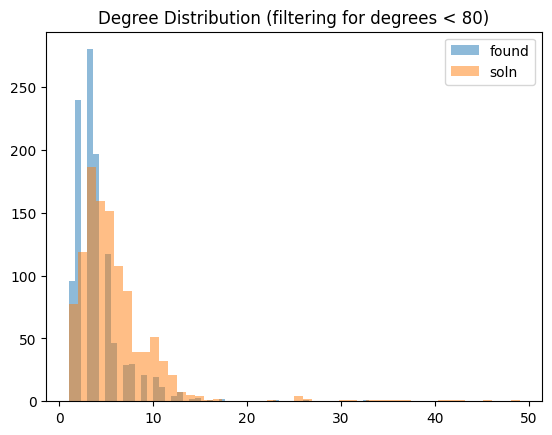

In [60]:
found_degrees = [x[1] for x in graph.degree()]
soln_degrees = [x[1] for x in soln_graph.degree()]

cap = 50

# filter for degrees < 100
found_degrees = [x for x in found_degrees if x < cap]
soln_degrees = [x for x in soln_degrees if x < cap]

plt.hist(found_degrees, bins=cap, alpha=0.5, label='found')
plt.hist(soln_degrees, bins=cap, alpha=0.5, label='soln')
plt.legend(loc='upper right')
plt.title('Degree Distribution (filtering for degrees < 80)')
plt.show()

### Edge "Lengths"

Considering edge length as the difference in magnitude from $parent \to child$

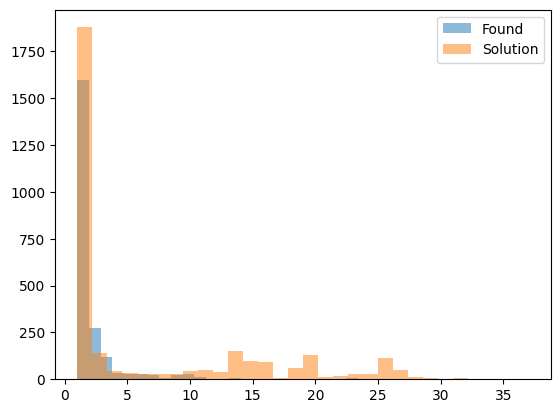

In [61]:
found_lengths = [len(child) - len(parent) for parent, child in graph.edges]
soln_lengths = [len(child) - len(parent) for parent, child in soln_graph.edges]

plt.hist(found_lengths, alpha=0.5, label='Found', bins=30)
plt.hist(soln_lengths, alpha=0.5, label='Solution', bins=30)
plt.legend()
plt.show()

As expected, edges that stretch a great "length" are ignored in the KNN-based graph. This is a good result.